In [2]:
!pip install opendatasets --upgrade -q
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 20.7 MB/s eta 0:00:00


In [3]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torchmetrics.classification import MulticlassF1Score, MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassConfusionMatrix
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.models as models
import matplotlib.pyplot as plt
import opendatasets as od
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline

In [4]:
dataset_url = 'https://www.kaggle.com/minbavel/cifar-100-images'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: wali24
Your Kaggle Key: ··········


100%|██████████| 140M/140M [00:03<00:00, 37.0MB/s]


In [5]:
project_name="ds281-resnet50-cifar-100-fine"

In [6]:
# I dowloaded the dataset using OpenDataset Library and by entering my Kaggle Key and Kaggle Username
# Let's look into the data directory
data_dir = './cifar-100-images/CIFAR100'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/TRAIN")
print(classes[:10])
print(len(classes))

['TEST', 'TRAIN']
['chimpanzee', 'bowl', 'leopard', 'spider', 'plain', 'castle', 'lion', 'crocodile', 'plate', 'cattle']
100


In [7]:
# Let's evaluate a single class say "man"
man_file=os.listdir(data_dir+"/TRAIN/man")
print("NO. of Training examples for Man:",len(man_file))
print(man_file[:5])

NO. of Training examples for Man: 500
['man_s_000864.png', 'adam_s_002330.png', 'cain_s_001298.png', 'adam_s_001343.png', 'man_s_001958.png']


In [8]:
# Let's see how many number of files/images are present in each classes
di={}
for i in classes:
    di[i]=len(os.listdir(data_dir+"/TRAIN/"+i))
print(di)

{'chimpanzee': 500, 'bowl': 500, 'leopard': 500, 'spider': 500, 'plain': 500, 'castle': 500, 'lion': 500, 'crocodile': 500, 'plate': 500, 'cattle': 500, 'road': 500, 'butterfly': 500, 'pine_tree': 500, 'tank': 500, 'mountain': 500, 'rabbit': 500, 'wardrobe': 500, 'aquarium_fish': 500, 'motorcycle': 500, 'bicycle': 500, 'lawn_mower': 500, 'caterpillar': 500, 'pear': 500, 'telephone': 500, 'bottle': 500, 'otter': 500, 'bus': 500, 'crab': 500, 'fox': 500, 'turtle': 500, 'pickup_truck': 500, 'willow_tree': 500, 'bear': 500, 'flatfish': 500, 'sea': 500, 'oak_tree': 500, 'lobster': 500, 'sunflower': 500, 'baby': 500, 'whale': 500, 'mouse': 500, 'wolf': 500, 'house': 500, 'lizard': 500, 'rocket': 500, 'skyscraper': 500, 'orchid': 500, 'tulip': 500, 'man': 500, 'forest': 500, 'porcupine': 500, 'mushroom': 500, 'tiger': 500, 'table': 500, 'palm_tree': 500, 'raccoon': 500, 'skunk': 500, 'worm': 500, 'elephant': 500, 'bee': 500, 'dolphin': 500, 'tractor': 500, 'lamp': 500, 'squirrel': 500, 'couch

In [9]:
average  = torch.Tensor([0,0,0])
standard_dev = torch.Tensor([0,0,0])
images = ImageFolder(data_dir+'/TRAIN', tt.ToTensor())
for image in images:
    average += image[0].mean([1,2])
    standard_dev += image[0].std([1,2])
average / len(images) , standard_dev / len(images)

(tensor([0.5071, 0.4865, 0.4409]), tensor([0.2009, 0.1984, 0.2023]))

In [10]:
# Data transforms (normalization & data augmentation)

stats = ((average / len(images)).tolist(), (standard_dev / len(images)).tolist())
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4,padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)
                        ])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)
                        ])

In [11]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/TRAIN', train_tfms)
valid_ds = ImageFolder(data_dir+'/TEST', valid_tfms)

In [12]:
# Let's use batch size
batch_size = 400

In [13]:

# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

In [14]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

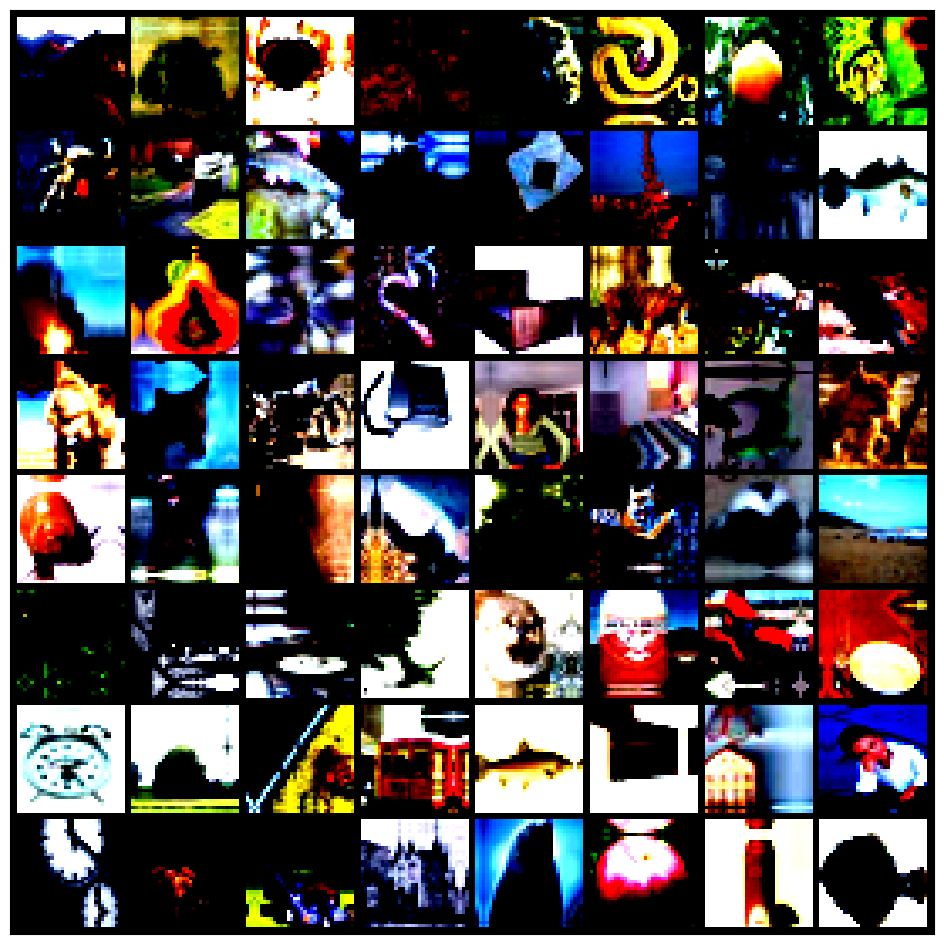

In [15]:
show_batch(train_dl);

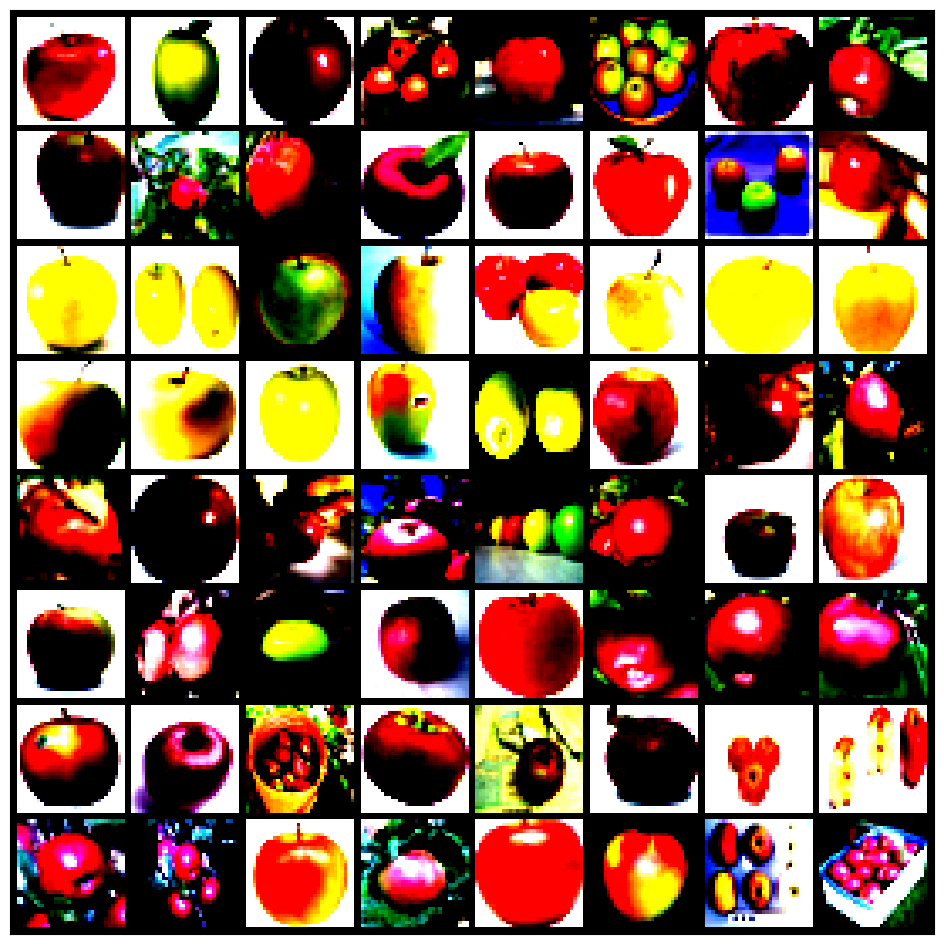

In [16]:
show_batch(valid_dl);

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cuda')

In [19]:
# Transfering data to the device in use (In our case GPU)
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [21]:
class BasicBlock(ImageClassificationBase):
    """Basic Block for resnet 18 and resnet 34
    """

    #BasicBlock and BottleNeck block
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class BottleNeck(ImageClassificationBase):
    """Residual block for resnet over 50 layers
    """
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(ImageClassificationBase):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block
        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer
        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet34():
    """ return a ResNet 34 object
    """
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    """ return a ResNet 50 object
    """
    return ResNet(BottleNeck, [3, 4, 6, 3])

def resnet101():
    """ return a ResNet 101 object
    """
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    """ return a ResNet 152 object
    """
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [22]:
model = to_device(resnet50(), device)
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2_x): Sequential(
    (0): BottleNeck(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stri

In [23]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [24]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 4.604822635650635, 'val_acc': 0.010865384712815285}]

In [25]:
epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay =1e-4
opt_func = torch.optim.Adam

In [26]:
#model.freeze()

In [27]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00103, train_loss: 4.0669, val_loss: 6.0927, val_acc: 0.1048
Epoch [1], last_lr: 0.00279, train_loss: 3.4536, val_loss: 3.3650, val_acc: 0.1929
Epoch [2], last_lr: 0.00519, train_loss: 2.9652, val_loss: 3.0475, val_acc: 0.2536
Epoch [3], last_lr: 0.00759, train_loss: 2.5778, val_loss: 2.8325, val_acc: 0.3041
Epoch [4], last_lr: 0.00936, train_loss: 2.3809, val_loss: 3.1039, val_acc: 0.2650
Epoch [5], last_lr: 0.01000, train_loss: 2.1926, val_loss: 2.4363, val_acc: 0.3570
Epoch [6], last_lr: 0.00987, train_loss: 2.0291, val_loss: 2.2707, val_acc: 0.4051
Epoch [7], last_lr: 0.00950, train_loss: 1.9243, val_loss: 2.6386, val_acc: 0.3593
Epoch [8], last_lr: 0.00891, train_loss: 1.8088, val_loss: 2.5590, val_acc: 0.3715
Epoch [9], last_lr: 0.00812, train_loss: 1.7248, val_loss: 2.0540, val_acc: 0.4540
Epoch [10], last_lr: 0.00717, train_loss: 1.6208, val_loss: 2.0297, val_acc: 0.4588
Epoch [11], last_lr: 0.00611, train_loss: 1.5175, val_loss: 1.8946, val_acc: 0.4788
Ep

In [28]:
#model.unfreeze()

In [29]:
%%time
history += fit_one_cycle(epochs, 0.001, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00010, train_loss: 0.5809, val_loss: 0.9830, val_acc: 0.7120
Epoch [1], last_lr: 0.00028, train_loss: 0.5821, val_loss: 0.9919, val_acc: 0.7113
Epoch [2], last_lr: 0.00052, train_loss: 0.5998, val_loss: 1.0440, val_acc: 0.7046
Epoch [3], last_lr: 0.00076, train_loss: 0.6325, val_loss: 1.1210, val_acc: 0.6850
Epoch [4], last_lr: 0.00094, train_loss: 0.6571, val_loss: 1.1499, val_acc: 0.6761
Epoch [5], last_lr: 0.00100, train_loss: 0.6668, val_loss: 1.0985, val_acc: 0.6889
Epoch [6], last_lr: 0.00099, train_loss: 0.6464, val_loss: 1.1225, val_acc: 0.6841
Epoch [7], last_lr: 0.00095, train_loss: 0.6126, val_loss: 1.1343, val_acc: 0.6848
Epoch [8], last_lr: 0.00089, train_loss: 0.5711, val_loss: 1.1334, val_acc: 0.6888
Epoch [9], last_lr: 0.00081, train_loss: 0.5315, val_loss: 1.1457, val_acc: 0.6864
Epoch [10], last_lr: 0.00072, train_loss: 0.4824, val_loss: 1.0951, val_acc: 0.7021
Epoch [11], last_lr: 0.00061, train_loss: 0.4318, val_loss: 1.0864, val_acc: 0.7055
Ep

In [30]:
%%time
history += fit_one_cycle(5, 0.0001, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00008, train_loss: 0.1599, val_loss: 1.0670, val_acc: 0.7354
Epoch [1], last_lr: 0.00010, train_loss: 0.1643, val_loss: 1.0822, val_acc: 0.7347
Epoch [2], last_lr: 0.00006, train_loss: 0.1585, val_loss: 1.0871, val_acc: 0.7344
Epoch [3], last_lr: 0.00002, train_loss: 0.1430, val_loss: 1.0841, val_acc: 0.7376
Epoch [4], last_lr: 0.00000, train_loss: 0.1347, val_loss: 1.0829, val_acc: 0.7367
CPU times: user 29.8 s, sys: 8.84 s, total: 38.6 s
Wall time: 2min 2s


In [31]:
%%time
history += fit_one_cycle(5, 0.00001, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00001, train_loss: 0.1344, val_loss: 1.0880, val_acc: 0.7373
Epoch [1], last_lr: 0.00001, train_loss: 0.1349, val_loss: 1.0867, val_acc: 0.7381
Epoch [2], last_lr: 0.00001, train_loss: 0.1346, val_loss: 1.0867, val_acc: 0.7381
Epoch [3], last_lr: 0.00000, train_loss: 0.1324, val_loss: 1.0907, val_acc: 0.7374
Epoch [4], last_lr: 0.00000, train_loss: 0.1310, val_loss: 1.0866, val_acc: 0.7374
CPU times: user 28.3 s, sys: 6.32 s, total: 34.6 s
Wall time: 2min 1s


In [32]:
%%time
history += fit_one_cycle(10, 0.0001, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00003, train_loss: 0.1314, val_loss: 1.0898, val_acc: 0.7367
Epoch [1], last_lr: 0.00008, train_loss: 0.1349, val_loss: 1.1028, val_acc: 0.7355
Epoch [2], last_lr: 0.00010, train_loss: 0.1373, val_loss: 1.1278, val_acc: 0.7313
Epoch [3], last_lr: 0.00010, train_loss: 0.1321, val_loss: 1.1312, val_acc: 0.7334
Epoch [4], last_lr: 0.00008, train_loss: 0.1278, val_loss: 1.1524, val_acc: 0.7343
Epoch [5], last_lr: 0.00006, train_loss: 0.1165, val_loss: 1.1507, val_acc: 0.7347
Epoch [6], last_lr: 0.00004, train_loss: 0.1090, val_loss: 1.1534, val_acc: 0.7371
Epoch [7], last_lr: 0.00002, train_loss: 0.1018, val_loss: 1.1554, val_acc: 0.7359
Epoch [8], last_lr: 0.00000, train_loss: 0.0985, val_loss: 1.1543, val_acc: 0.7355
Epoch [9], last_lr: 0.00000, train_loss: 0.0963, val_loss: 1.1556, val_acc: 0.7369
CPU times: user 59.9 s, sys: 17.7 s, total: 1min 17s
Wall time: 4min 6s


In [33]:
train_time='00:22:00'

In [34]:
# Plotted the accuracy Graph
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

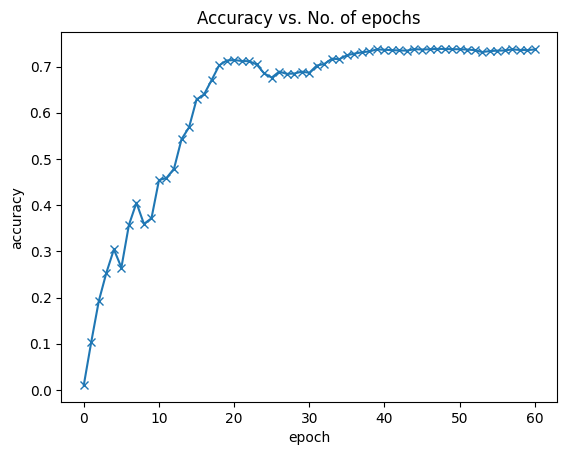

In [35]:
plot_accuracies(history)

In [36]:
# Training and Validation loss graph
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

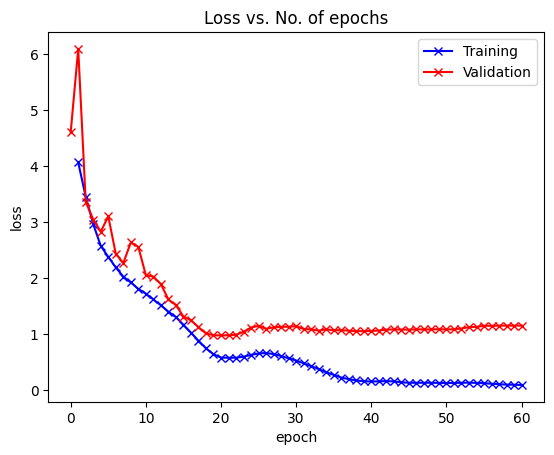

In [37]:
plot_losses(history)

In [38]:
# Learning Rate Graph
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

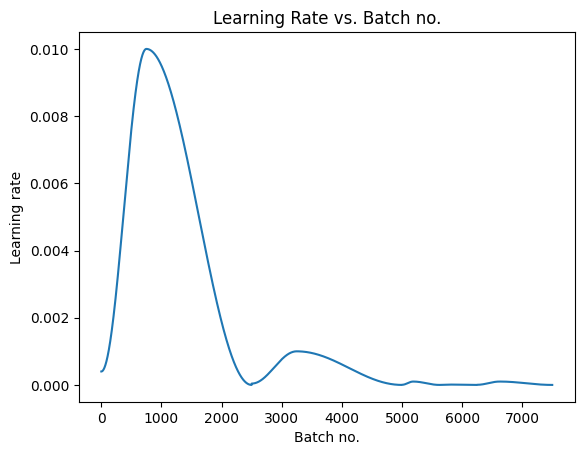

In [39]:
plot_lrs(history)

In [40]:
from torchvision.transforms import ToTensor
test_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)
                        ])
test_dataset = ImageFolder(data_dir+'/TEST', test_tfms)

In [41]:
dataset = ImageFolder(data_dir+'/TRAIN', transform=ToTensor())

In [42]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: bed , Predicted: bed


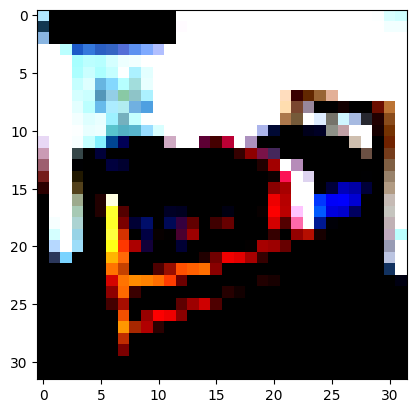

In [43]:

img, label = test_dataset[550]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: apple , Predicted: apple


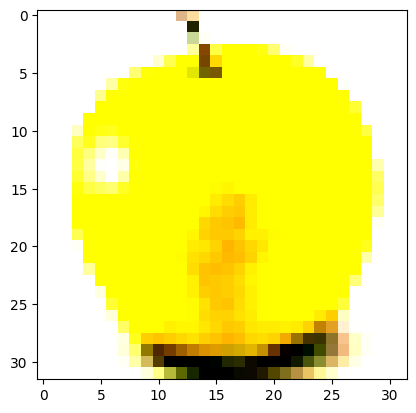

In [44]:
img, label = test_dataset[16]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: aquarium_fish , Predicted: aquarium_fish


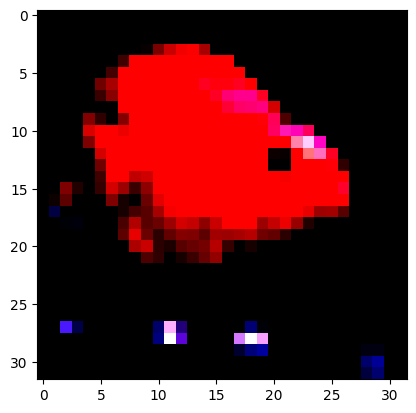

In [45]:

img, label = test_dataset[117]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: baby , Predicted: baby


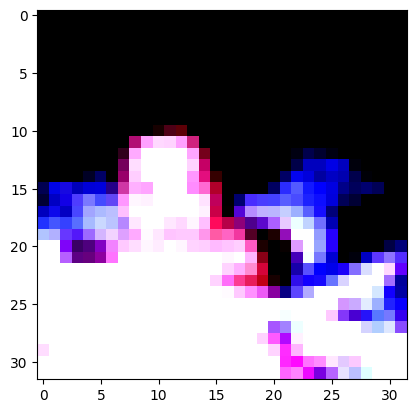

In [46]:

img, label = test_dataset[210]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: bed , Predicted: bed


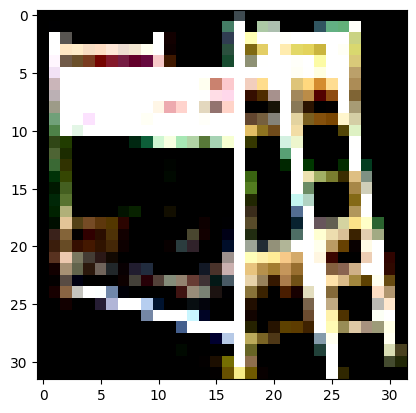

In [47]:
img, label = test_dataset[589]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [48]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 1.1555994749069214, 'val_acc': 0.736923098564148}

In [49]:
PATH = 'ds281-resnet50-cifar100-fine'

torch.save(model.state_dict(), PATH)

In [50]:
model2 = to_device(resnet50(), device)

In [51]:
model2.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [52]:
evaluate(model2, test_loader)

{'val_loss': 1.1555994749069214, 'val_acc': 0.736923098564148}

In [53]:
dataset_test_dict = {'image':[], 'actual_label':[], 'predicted_label':[]}
for img, actual_label in test_dataset:
  dataset_test_dict['image'].append(img)
  dataset_test_dict['actual_label'].append(actual_label)
  dataset_test_dict['predicted_label'].append(dataset.classes.index(predict_image(img, model)))

In [54]:
# Store the Predictions in a Data Frame
dataset_test_results_df = pd.DataFrame (dataset_test_dict, columns = ['image', 'actual_label','predicted_label'])
# Extract the Actual and Predicted Labels and convert into tensors
y_test_act_arr = torch.tensor(dataset_test_results_df[['actual_label']].values.flatten())
y_test_pred_arr = torch.tensor(dataset_test_results_df[['predicted_label']].values.flatten())

In [55]:
mcf1s = MulticlassF1Score(num_classes=100, average='macro')
f1score = mcf1s(y_test_pred_arr, y_test_act_arr)
mca = MulticlassAccuracy(num_classes=100, average='macro')
accuracy = mca(y_test_pred_arr, y_test_act_arr)
mcp = MulticlassPrecision(num_classes=100, average='macro')
precision = mcp(y_test_pred_arr, y_test_act_arr)
mcr = MulticlassRecall(num_classes=100, average='macro')
recall = mcr(y_test_pred_arr, y_test_act_arr)
metric = MulticlassConfusionMatrix(num_classes=100)
cm = metric(y_test_pred_arr, y_test_act_arr)
print('F1 score = %.3f,' % (f1score*100), 'Accuracy = %.3f,' % (accuracy*100), 'Precision = %.3f,' % (precision*100), 'Recall = %.3f ' % (recall*100))

F1 score = 73.859, Accuracy = 73.860, Precision = 74.106, Recall = 73.860 


In [56]:
def plot_conf(y_test_act_arr, y_test_pred_arr, label : str = "", figsize=(15,15)) :
    cm = confusion_matrix(y_test_act_arr, y_test_pred_arr)
    fig, ax = plt.subplots(figsize=figsize)         # Sample figsize in inches
    fig.suptitle("confusion matrix %s"%label)
    f = sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

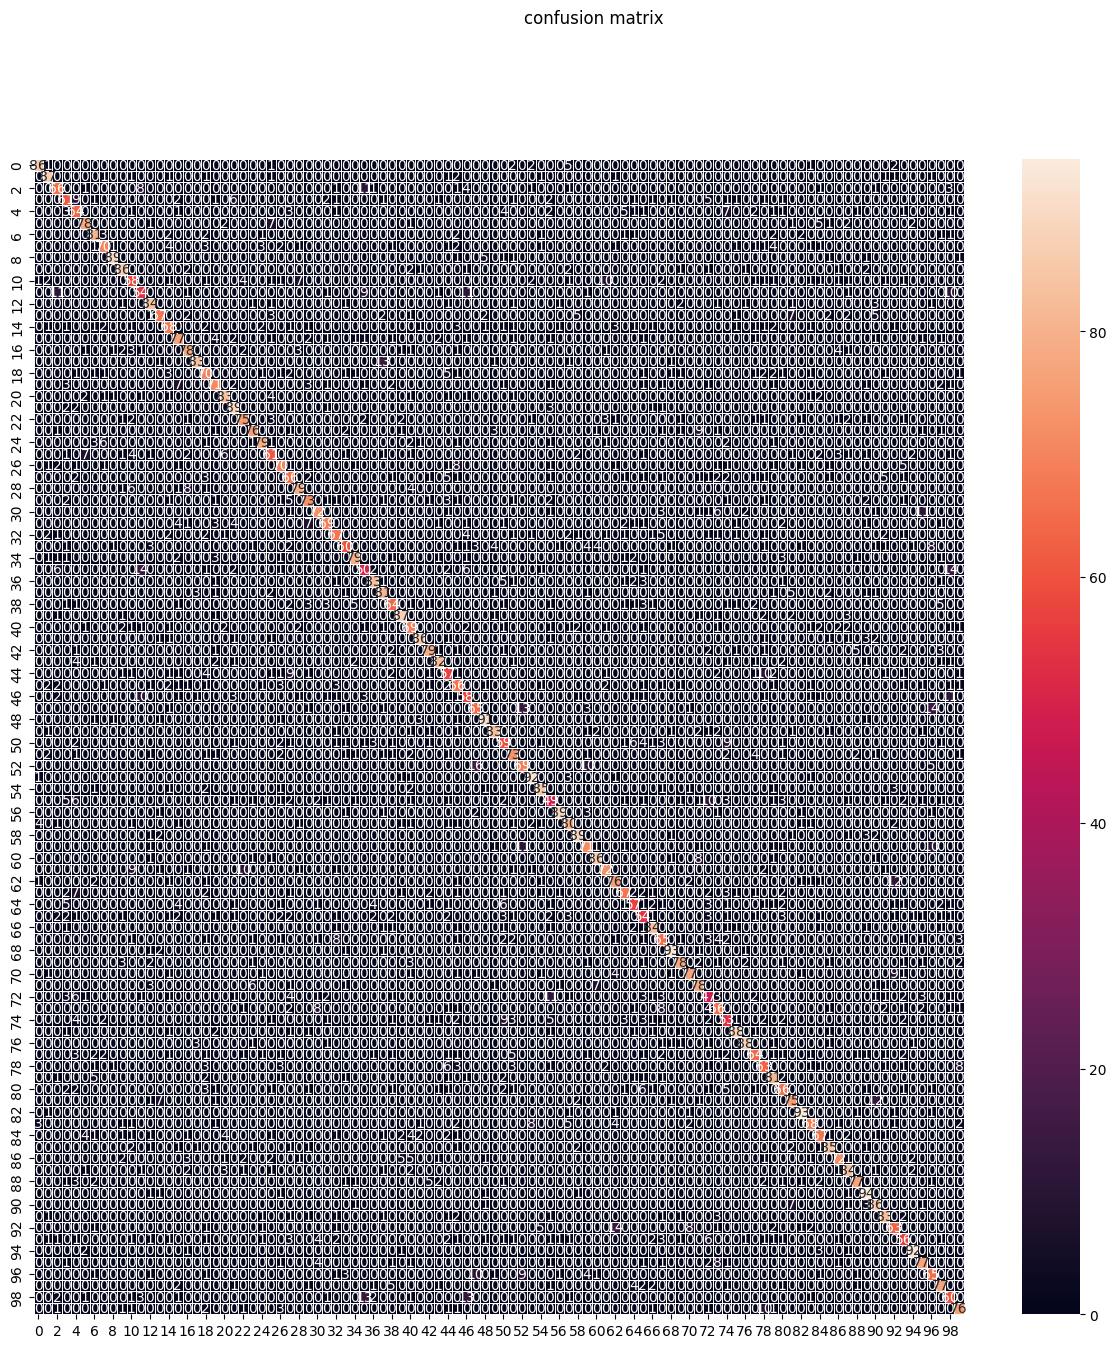

In [57]:
plot_conf(y_test_act_arr, y_test_pred_arr)